### Project description

This project is related to the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans is more profitable in order to adjust the advertising budget.


I'm going to carry out a preliminary analysis of the plans based on a relatively small client selection. I have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. In this project I'll analyze clients' behavior and determine which prepaid plan is more profitable.

Load data and essential libraries

In [1]:
#libraries
import pandas as pd
import numpy as np
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "svg"
import seaborn as sb
from scipy.stats import mannwhitneyu

#data
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users1.csv')


**Step 1. Open the data file and study the general information**

In [2]:
print(len(calls))
calls.head(2)

137735


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [4]:
print(len(internet))
internet.head(2)

104825


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [6]:
print(len(messages))
messages.head(2)

76051


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [8]:
print(len(plans))
plans.head(2)

2


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [9]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [10]:
print(len(users))
users.head(2)

500


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**Step 2. Prepare the data**
>- Convert the data to the necessary types
- Find and eliminate errors in the data

First, I'll convert date related columns to datetime format.

Second, I'll use merge method, consequentially merging one dataframe with another. And I'll use fillna()
method at the end to fill missing data with 0.

In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT%H:%M:%S')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT%H:%M:%S')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%dT%H:%M:%S')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%dT%H:%M:%S')

In [13]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month
users['reg_month'] = users['reg_date'].dt.month
users['churn_month'] = users['churn_date'].dt.month

In [14]:
calls_group = calls.groupby(['user_id','month'])['duration'].agg(['count','sum'])
calls_group.columns = ['calls','duration']
calls_group.head(2)

,,calls,duration
user_id,month,,
1000,12,16,116.83
1001,8,27,171.14


In [15]:
internet_group = internet.groupby(['user_id','month'])['mb_used'].sum()

In [16]:
messages_group = messages.groupby(['user_id','month'])['message_date'].agg(['count'])
messages_group.columns = ['messages']
messages_group.head(2)

,,messages
user_id,month,
1000,12,11
1001,8,30


In [17]:
total1 = pd.merge(left = internet_group , right = calls_group, how='outer',on=['user_id', 'month']).fillna(0)
total2 = pd.merge(left = total1 , right = messages_group, how='outer',on=['user_id', 'month']).fillna(0).reset_index()

>For each user, find:
- The number of calls made and minutes used per month
- The number of text messages sent per month
- The volume of data per month

In [18]:
print(len(total2))
total2

2293


,user_id,month,mb_used,calls,duration,messages
0,1000,12,1901.47,16.0,116.83,11.0
1,1001,8,6919.15,27.0,171.14,30.0
2,1001,9,13314.82,49.0,297.69,44.0
3,1001,10,22330.49,65.0,374.11,53.0
4,1001,11,18504.30,64.0,404.59,36.0
...,...,...,...,...,...,...
2288,1470,11,0.00,81.0,602.30,156.0
2289,1470,12,0.00,78.0,560.44,153.0
2290,1484,11,0.00,2.0,37.50,1.0
2291,1491,4,0.00,8.0,40.45,6.0


I'll also print out a table with an average use of each parameter per month per user.

In [19]:
Avg_use_month = total2.pivot_table(index='user_id', values=['calls', 'duration', 'mb_used'], aggfunc='mean').reset_index()
Avg_use_month

,user_id,calls,duration,mb_used
0,1000,16.000000,116.830000,1901.470000
1,1001,52.200000,328.092000,16087.588000
2,1002,37.666667,259.043333,13431.110000
3,1003,149.000000,1041.000000,27044.140000
4,1004,46.250000,327.368750,19544.101250
...,...,...,...,...
485,1495,63.250000,416.602500,24722.740000
486,1496,39.000000,275.242000,12853.728000
487,1497,54.000000,276.530000,11106.550000
488,1498,41.000000,275.451818,20684.102727


In [20]:
plans.rename(columns = {'plan_name':'plan'}, inplace = True)

In [21]:
users_plan = users[['user_id', 'plan', 'city', 'churn_month', 'reg_month']]
plan_merge = pd.merge(left = users_plan, right = plans, how='outer',on='plan').fillna(0)

In [22]:
total = pd.merge(left = total2, right = plan_merge, how='outer',on='user_id').fillna(0)
print(len(total))
total.head(2)

2303


,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12.0,1901.47,16.0,116.83,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,12,1000,30720,3000,70,7,0.01,0.01
1,1001,8.0,6919.15,27.0,171.14,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,50,15360,500,20,10,0.03,0.03


In [23]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2303 non-null   int64  
 1   month                  2303 non-null   float64
 2   mb_used                2303 non-null   float64
 3   calls                  2303 non-null   float64
 4   duration               2303 non-null   float64
 5   messages               2303 non-null   float64
 6   plan                   2303 non-null   object 
 7   city                   2303 non-null   object 
 8   churn_month            2303 non-null   float64
 9   reg_month              2303 non-null   int64  
 10  messages_included      2303 non-null   int64  
 11  mb_per_month_included  2303 non-null   int64  
 12  minutes_included       2303 non-null   int64  
 13  usd_monthly_pay        2303 non-null   int64  
 14  usd_per_gb             2303 non-null   int64  
 15  usd_

In [24]:
total['month'] = total['month'].astype('int')

In [25]:
total.describe()

,user_id,month,mb_used,calls,duration,messages,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.00000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000,2303.000000
mean,1246.214937,9.132870,16691.603869,59.806774,403.452132,33.022579,0.719931,4.893617,348.65393,20188.762484,1285.931394,35.718628,9.056882,0.023713,0.023713
std,143.044136,2.562964,8026.001447,32.572548,224.485210,34.065907,2.660353,2.989188,441.14801,7132.666777,1160.915817,23.218316,1.393099,0.009287,0.009287
min,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,50.00000,15360.000000,500.000000,20.000000,7.000000,0.010000,0.010000
25%,1122.000000,8.000000,12185.215000,38.000000,247.755000,3.000000,0.000000,2.000000,50.00000,15360.000000,500.000000,20.000000,7.000000,0.010000,0.010000
50%,1245.000000,10.000000,16803.260000,60.000000,398.970000,25.000000,0.000000,4.000000,50.00000,15360.000000,500.000000,20.000000,10.000000,0.030000,0.030000
75%,1368.000000,11.000000,20993.075000,79.000000,539.595000,51.000000,0.000000,7.000000,1000.00000,30720.000000,3000.000000,70.000000,10.000000,0.030000,0.030000
max,1499.000000,12.000000,70931.590000,205.000000,1431.220000,266.000000,12.000000,12.000000,1000.00000,30720.000000,3000.000000,70.000000,10.000000,0.030000,0.030000


For some reason there're 0's in the month column. It could be an error. I'll check how the rest of data with month = 0 looks. how many rows it affects.

In [26]:
total[total['month'] == 0].count()

user_id                  10
month                    10
mb_used                  10
calls                    10
duration                 10
messages                 10
plan                     10
city                     10
churn_month              10
reg_month                10
messages_included        10
mb_per_month_included    10
minutes_included         10
usd_monthly_pay          10
usd_per_gb               10
usd_per_message          10
usd_per_minute           10
dtype: int64

In [27]:
total[total['month'] == 0]

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
2293,1025,0,0.0,0.0,0.0,0.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,10,1000,30720,3000,70,7,0.01,0.01
2294,1269,0,0.0,0.0,0.0,0.0,ultimate,"Dallas-Fort Worth-Arlington, TX MSA",12.0,9,1000,30720,3000,70,7,0.01,0.01
2295,1275,0,0.0,0.0,0.0,0.0,ultimate,"New York-Newark-Jersey City, NY-NJ-PA MSA",0.0,11,1000,30720,3000,70,7,0.01,0.01
2296,1463,0,0.0,0.0,0.0,0.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,11,1000,30720,3000,70,7,0.01,0.01
2297,1129,0,0.0,0.0,0.0,0.0,surf,"Baton Rouge, LA MSA",12.0,11,50,15360,500,20,10,0.03,0.03
2298,1143,0,0.0,0.0,0.0,0.0,surf,"Cincinnati, OH-KY-IN MSA",0.0,10,50,15360,500,20,10,0.03,0.03
2299,1307,0,0.0,0.0,0.0,0.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",0.0,12,50,15360,500,20,10,0.03,0.03
2300,1319,0,0.0,0.0,0.0,0.0,surf,"Colorado Springs, CO MSA",0.0,6,50,15360,500,20,10,0.03,0.03
2301,1378,0,0.0,0.0,0.0,0.0,surf,"Denver-Aurora-Lakewood, CO MSA",0.0,12,50,15360,500,20,10,0.03,0.03
2302,1473,0,0.0,0.0,0.0,0.0,surf,"Louisville/Jefferson County, KY-IN MSA",0.0,12,50,15360,500,20,10,0.03,0.03


Looks like an error, because those users didn't call, sent messages or used an internet. For futher analysis those rows don't bring any value, so I'll drop them.

In [28]:
total.drop(total[total['month'] == 0].index, axis=0, inplace=True)
total[total['month'] == 0]

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute


In [29]:
total.describe()

,user_id,month,mb_used,calls,duration,messages,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1246.075883,9.172700,16764.397606,60.067597,405.211627,33.166594,0.712604,4.869603,348.299171,20183.026603,1284.997819,35.699956,9.058003,0.023720,0.023720
std,143.051927,2.496386,7967.237527,32.402563,223.383523,34.070085,2.644894,2.971212,441.006389,7130.376976,1160.543128,23.210863,1.392652,0.009284,0.009284
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,50.000000,15360.000000,500.000000,20.000000,7.000000,0.010000,0.010000
25%,1122.000000,8.000000,12235.760000,38.000000,249.130000,3.000000,0.000000,2.000000,50.000000,15360.000000,500.000000,20.000000,7.000000,0.010000,0.010000
50%,1245.000000,10.000000,16830.640000,60.000000,400.160000,26.000000,0.000000,4.000000,50.000000,15360.000000,500.000000,20.000000,10.000000,0.030000,0.030000
75%,1368.000000,11.000000,20999.840000,79.000000,540.450000,51.000000,0.000000,7.000000,1000.000000,30720.000000,3000.000000,70.000000,10.000000,0.030000,0.030000
max,1499.000000,12.000000,70931.590000,205.000000,1431.220000,266.000000,12.000000,12.000000,1000.000000,30720.000000,3000.000000,70.000000,10.000000,0.030000,0.030000


I see that min for mb_used, calls and messages = 0. I'll check if there any user, who has all zeros. It this case I'll need to investigate such rows.

In [30]:
all_zero = total[(total['mb_used']==0 ) & (total['calls'] ==0) & (total['messages'] ==0)]
all_zero

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute


No users, who bought the packege and didn't use it.
The next step, I'll check if there any NULLs in the data.

In [31]:
missing_data=[]
for col in total:
    missing_data.append([col,(len(total[total[col].isnull()]/len(total)))])
missing_data = pd.DataFrame(missing_data, columns=['column','missing %'])
missing_data.sort_values(by=['missing %'], ascending=False)

,column,missing %
0,user_id,0
9,reg_month,0
15,usd_per_message,0
14,usd_per_gb,0
13,usd_monthly_pay,0
12,minutes_included,0
11,mb_per_month_included,0
10,messages_included,0
8,churn_month,0
1,month,0


I'll check how many 0's in the columns 'duration' and 'mb_used'.

In [32]:
print(total[total['duration'] == 0].shape[0])
print('----------------------')
print(total[total['mb_used'] == 0].shape[0])

37
----------------------
16


I'll replace 0's with 1's, because the duration of call could be so short, that it wasn't registered. The same for the mb_used.

In [33]:
total['duration'] = total['duration'].replace(0,1)
total['mb_used'] = total['mb_used'].replace(0,1)

In [34]:
#Check
print(total[total['duration'] == 0].shape[0])
print('----------------------')
print(total[total['mb_used'] == 0].shape[0])

0
----------------------
0


I'll check if there are any users with the activity before registration date and past the churn date.

In [35]:
reg_activity_check = total[(total['month'] < total['reg_month'])]
print(reg_activity_check.shape[0])

0


In [36]:
churn_activity_check = total[(total['churn_month'] < total['month']) & (total['churn_month'] >0)]
print(churn_activity_check.shape[0])

37


As all data related to the 2018Y, I exclude the case that churn date happened in the next year. I would consider the rows where users still have an activity after a churn day as a mistake and drop them. There're only 37 rows with the weird data, so it is less than 10% of all data and can be dropped without affecting the analysis.

In [37]:
total.drop(total[(total['churn_month'] < total['month']) & (total['churn_month'] >0)].index, axis=0, inplace=True)

In [38]:
churn_activity_check = total[(total['churn_month'] < total['month']) & (total['churn_month'] >0)]
print(churn_activity_check.shape[0])

0


I see that costs for an internet in each plan are written in GB, but the initial data provided in MB, so for the convinience of the futher analysis I'll add columns with GB as well.

I'll also add column with the total minutes used per each user, as the duration of the calls impacts the total cost at the end of the month.

In [39]:
total['gb_used'] = total['mb_used'] / 1024

In [40]:
total['gb_per_month_included'] = total['mb_per_month_included'] / 1024

In [41]:
total['minutes_used'] = total['duration']

>For each user, find:
The monthly profit from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)

In [42]:
total.head(2)

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used
0,1000,12,1901.47,16.0,116.83,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,12,1000,30720,3000,70,7,0.01,0.01,1.856904,30.0,116.83
1,1001,8,6919.15,27.0,171.14,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,50,15360,500,20,10,0.03,0.03,6.756982,15.0,171.14


I'll use .ceil method to round up GBs_used and minutes_used with accordance to the condition: if the call lasted just one second, it will be counted as one minute, and if one megabyte of data was used, it will be counted as one gigabyte.

In [43]:
total['gb_used'] = np.ceil(total['gb_used']).astype(int)
total['minutes_used'] = np.ceil(total['minutes_used']).astype(int)


Investigated the rows with churn date and registration date and dropped the ones with the weird data.

For each paramenter: messages, GBs, and Calls I'll add 3 columns with the data after exceeding the package limits.
In case if included in tariff options weren'r exceed, the function will return "0".

In [44]:
def over_mes (row):
    messages_included = row['messages_included']
    messages_used = row['messages']
    
    if messages_included < messages_used:
        return  messages_used - messages_included

    if messages_included >= messages_used:
        return '0'

total['mes_above_limit'] = total.apply(over_mes, axis=1)

In [45]:
def over_gb (row):
    gb_included = row['gb_per_month_included']
    gb_used = row['gb_used']
    
    if gb_included < gb_used:
        return  gb_used - gb_included

    if gb_included >= gb_used:
        return '0'

total['gb_above_limit'] = total.apply(over_gb, axis=1)

In [46]:
def over_calls (row):
    minutes_included = row['minutes_included']
    minutes_used = row['minutes_used']
    
    if minutes_included < minutes_used:
        return  minutes_used - minutes_included

    if minutes_included >= minutes_used:
        return '0'

total['min_above_limit'] = total.apply(over_calls, axis=1)

In [47]:
total.head(2)

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used,mes_above_limit,gb_above_limit,min_above_limit
0,1000,12,1901.47,16.0,116.83,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,12,...,70,7,0.01,0.01,2,30.0,117,0,0,0
1,1001,8,6919.15,27.0,171.14,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,20,10,0.03,0.03,7,15.0,172,0,0,0


In [48]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256 entries, 0 to 2292
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2256 non-null   int64  
 1   month                  2256 non-null   int32  
 2   mb_used                2256 non-null   float64
 3   calls                  2256 non-null   float64
 4   duration               2256 non-null   float64
 5   messages               2256 non-null   float64
 6   plan                   2256 non-null   object 
 7   city                   2256 non-null   object 
 8   churn_month            2256 non-null   float64
 9   reg_month              2256 non-null   int64  
 10  messages_included      2256 non-null   int64  
 11  mb_per_month_included  2256 non-null   int64  
 12  minutes_included       2256 non-null   int64  
 13  usd_monthly_pay        2256 non-null   int64  
 14  usd_per_gb             2256 non-null   int64  
 15  usd_

I'll convert new columns with data above limit to the integer type.

In [49]:
total['mes_above_limit'] = total['mes_above_limit'].astype('int')
total['gb_above_limit'] = total['gb_above_limit'].astype('int')
total['min_above_limit'] = total['min_above_limit'].astype('int')

Next, I'll calculate the profit from each user, by calling the function "cost".

In [50]:
def cost(row):
    calls = row['min_above_limit']
    internet = row['gb_above_limit']
    sms = row['mes_above_limit']
    monthly_pay = row['usd_monthly_pay']
    calls_price = row['usd_per_minute']
    internet_price = row['usd_per_gb']
    sms_price = row['usd_per_message']



    if calls == 0:
        cost_calls = 0
    else:
        cost_calls = calls_price * calls

    if internet == 0:
        internet_cost = 0
    else:
        internet_cost = internet_price * internet
 
    if sms == 0:
        sms_cost = 0
    else:
        sms_cost = sms_price * sms
            
    total_cost = monthly_pay + cost_calls + internet_cost + sms_cost
    return total_cost

total['total_cost'] = total.apply(cost,axis=1)
total.head(2)

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,...,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used,mes_above_limit,gb_above_limit,min_above_limit,total_cost
0,1000,12,1901.47,16.0,116.83,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,12,...,7,0.01,0.01,2,30.0,117,0,0,0,70.0
1,1001,8,6919.15,27.0,171.14,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,10,0.03,0.03,7,15.0,172,0,0,0,20.0


In [51]:
total.head(5)

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,...,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used,mes_above_limit,gb_above_limit,min_above_limit,total_cost
0,1000,12,1901.47,16.0,116.83,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,12,...,7,0.01,0.01,2,30.0,117,0,0,0,70.00
1,1001,8,6919.15,27.0,171.14,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,10,0.03,0.03,7,15.0,172,0,0,0,20.00
2,1001,9,13314.82,49.0,297.69,44.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,10,0.03,0.03,14,15.0,298,0,0,0,20.00
3,1001,10,22330.49,65.0,374.11,53.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,10,0.03,0.03,22,15.0,375,3,7,0,90.09
4,1001,11,18504.30,64.0,404.59,36.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,10,0.03,0.03,19,15.0,405,0,4,0,60.00


Average monthly profit for each user will be:

In [52]:
avg_monthly_profit_per_user = total.pivot_table(index=['user_id','plan'], values ='total_cost', aggfunc='mean') \
.reset_index()
avg_monthly_profit_per_user.sort_values(by = 'total_cost')

,user_id,plan,total_cost
77,1078,surf,20.000000
450,1461,surf,20.000000
23,1023,surf,20.000000
413,1423,surf,20.000000
403,1413,surf,20.000000
...,...,...,...
144,1147,surf,198.101250
237,1240,surf,234.760000
287,1292,surf,263.333333
120,1121,surf,275.705000


### Step 3. Analyze the data

>Describe the customers' behavior. Find the minutes, texts, and volume of data the users of each plan require per month.
Calculate the mean, dispersion, and standard deviation. Plot histograms. Describe the distributions.

**Surf plan**

In [53]:
plan_surf = total.query('plan == "surf"')
plan_pivot_surf = plan_surf.pivot_table(index=['plan'], values=['messages','gb_used', 'minutes_used'], aggfunc='mean').reset_index()
plan_pivot_surf

,plan,gb_used,messages,minutes_used
0,surf,16.681525,31.111757,405.322997


In avarage the users of surf plan require: 16.7 GB, 31 sms and 31,158 minutes per month.

To get the central tendency of the data, I'll caculate Interquartile Range (IQR).

In [54]:
surf_parameters = plan_surf[['messages', 'gb_used', 'minutes_used' ]]

In [55]:
for x in surf_parameters:

    Q1 = np.percentile(plan_surf[x], 25, interpolation = 'midpoint') 
    Q3 = np.percentile(plan_surf[x], 75, interpolation = 'midpoint') 
    IQR = Q3 - Q1 
  
    print('Surf tariff IQR of {: <12}'.format(x), IQR, ' Q1 = {}'.format(Q1), ' Q3 = {}'.format(Q3))

Surf tariff IQR of messages     44.0  Q1 = 3.0  Q3 = 47.0
Surf tariff IQR of gb_used      9.0  Q1 = 12.0  Q3 = 21.0
Surf tariff IQR of minutes_used 289.0  Q1 = 255.5  Q3 = 544.5


I'll also use boxplots for each plan to display the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). 

I'll identify outliers and what their values are.

In [56]:
plan_ultimate = total.query('plan == "ultimate"')

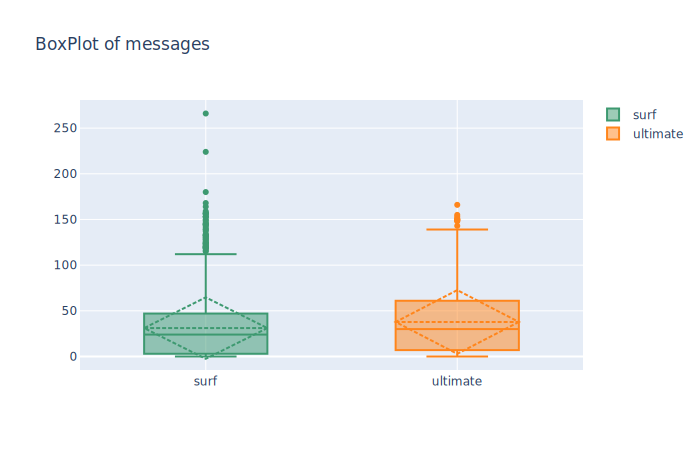

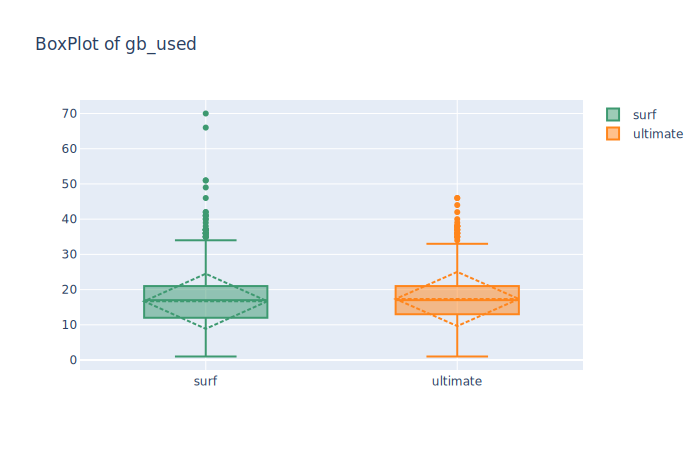

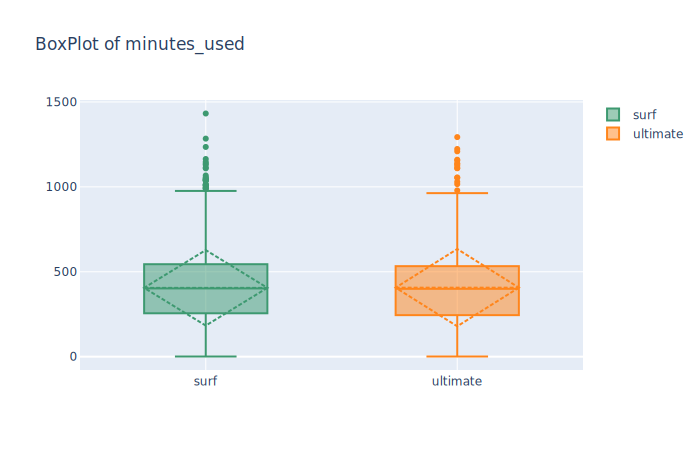

In [57]:
surf = plan_surf[['messages', 'gb_used', 'minutes_used']]
ultimate = plan_ultimate[['messages', 'gb_used', 'minutes_used']]

for (x,i) in zip(surf, ultimate):

    fig = go.Figure()
    fig.add_trace(go.Box(y=surf[x], name='surf',
                        marker_color = '#3D9970',
                        boxmean='sd',
   
                        ))
        
   
                  
    fig.add_trace(go.Box(y=ultimate[i], name = 'ultimate',
                        marker_color = '#FF851B',
                            boxmean='sd',
                        ))

    
    fig.update_layout(
    title='BoxPlot of {}'.format(x))
    
                      


    fig.show()

Using the graphs above, we can compare the range and distribution of the area_mean for surf and ultimate plans. 
We observe that there're larger outliers of all parameters for this plan. 
For messages the ultimate plan showed a greater variability than the surf plan.
Both plans are right skewed for such parameters as: messages and minutes used.

Nex step is calculate standart deviation and to plot histograms for each parameter for surf plan.

In [58]:
for x in surf_parameters:
    surf_variance = round(np.var(plan_surf[x]))  
    print('Surf variance of {: <12}'.format(x), surf_variance,)

Surf variance of messages     1131
Surf variance of gb_used      61
Surf variance of minutes_used 49422


In [59]:
for x in surf_parameters:
    surf_st_dev = np.std(plan_surf[x]) 
    print('Standard deviation of {: <12}'.format(x), surf_st_dev)

Standard deviation of messages     33.63024419035286
Standard deviation of gb_used      7.818102940807733
Standard deviation of minutes_used 222.31047222356887


In [60]:
for x in surf_parameters:
    surf_top_line = round(plan_surf[x].mean() + 3 * np.std(plan_surf[x]))  
    print('Top line of {: <12}'.format(x), surf_top_line)

Top line of messages     132
Top line of gb_used      40
Top line of minutes_used 1072


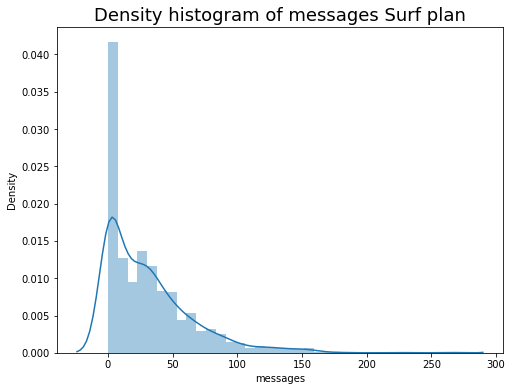

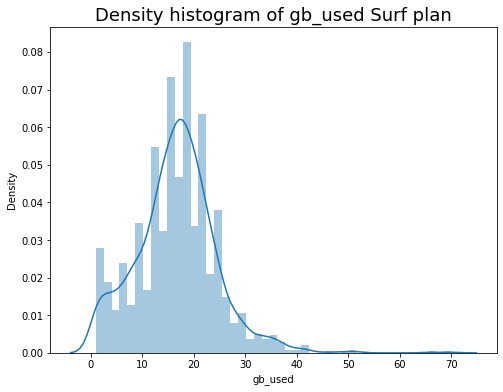

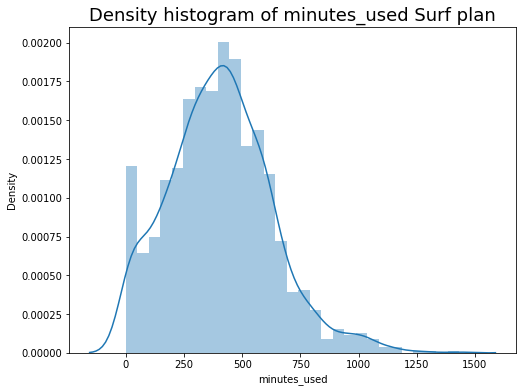

In [61]:
for i, col in enumerate(surf_parameters.columns):
        plt.figure(i, figsize=(8,6))
        sb.distplot(surf_parameters[col])
        plt.title("Density histogram of " + surf_parameters.columns[i] + " Surf plan", fontsize=18)
        plt.ylabel('Density', fontsize=10)
        plt.show()

Average number sms per month will be 31. The message hist shows a right-skewed distribution, indicating that there are a number of values greater than the mode.

Mean and median for gb used is almost the same: 16.67 and 16, which mean that data is simmetrical and distributed normally. Average gb per month used = 16.67.

Minutes used has outliers and mean value = 405.

- Standard deviation of messages:     33.5
- Standard deviation of gb:      7.8
- Standard deviation of minutes: 222.3

Before making any conclusions. I'll investigate the Ultimate plan data as well.

**Ultimate plan**

In [62]:
plan_ultimate = total.query('plan == "ultimate"')
plan_pivot_ultimate = plan_ultimate.pivot_table(index=['plan'], values=['messages','gb_used', 'minutes_used']).reset_index()
plan_pivot_ultimate.columns = ['plan', 'avg_gb_used', 'avg_messages_used', 'avg_minutes_used '] 
plan_pivot_ultimate

,plan,avg_gb_used,avg_messages_used,avg_minutes_used
0,ultimate,17.336158,37.798023,406.443503


In [63]:
ultimate_parameters = plan_ultimate[['messages', 'gb_used', 'minutes_used' ]]

In [64]:
for x in ultimate_parameters:

    Q1 = np.percentile(plan_ultimate[x], 25, interpolation = 'midpoint') 
    Q3 = np.percentile(plan_ultimate[x], 75, interpolation = 'midpoint') 
    IQR = Q3 - Q1 
  
    print('Ultimate tariff IQR of {: <12}'.format(x), IQR, ' Q1 = {}'.format(Q1), ' Q3 = {}'.format(Q3))

Ultimate tariff IQR of messages     54.0  Q1 = 7.0  Q3 = 61.0
Ultimate tariff IQR of gb_used      8.0  Q1 = 13.0  Q3 = 21.0
Ultimate tariff IQR of minutes_used 288.5  Q1 = 244.5  Q3 = 533.0


In [65]:
for x in ultimate_parameters:
    ultimate_variance = round(np.var(plan_ultimate[x]))  
    print('Ultimate variance of {: <12}'.format(x), ultimate_variance)

Ultimate variance of messages     1216
Ultimate variance of gb_used      59
Ultimate variance of minutes_used 51774


In [66]:
for x in ultimate_parameters:
    ultimate_st_dev = np.std(plan_ultimate[x]) 
    print('Standard deviation of {: <12}'.format(x), ultimate_st_dev)

Standard deviation of messages     34.871396442861155
Standard deviation of gb_used      7.692170275390215
Standard deviation of minutes_used 227.5399224303169


In [67]:
for x in ultimate_parameters:
    ultimate_top_line = round(plan_ultimate[x].mean() + 3 * np.std(plan_ultimate[x]))  
    print('Top line of {: <12}'.format(x), ultimate_top_line)

Top line of messages     142
Top line of gb_used      40
Top line of minutes_used 1089


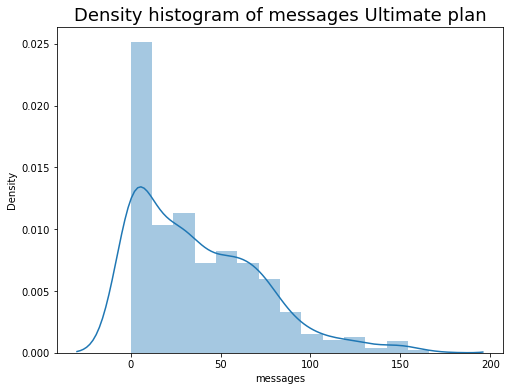

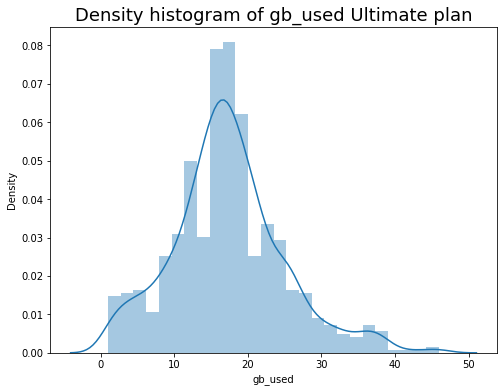

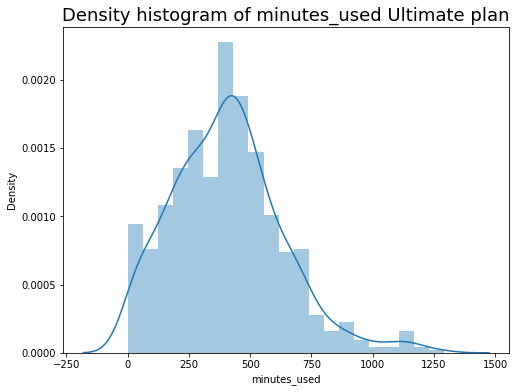

In [68]:
for i, col in enumerate(ultimate_parameters.columns):
        plt.figure(i, figsize=(8,6))
        sb.distplot(ultimate_parameters[col], label="ultimate")
        plt.title("Density histogram of " + ultimate_parameters.columns[i] + " Ultimate plan", fontsize=18)
        plt.ylabel('Density', fontsize=10)

Average number sms per month will be 38. The message hist shows a right-skewed distribution (the same as for surf plan), indicating that there are a number of values greater than the mode. 
Mean and median for gb used is almost the same: 17 and 17.3 accordingly, which mean that data is simmetrical and distributed normally. 
Minutes used has outliers and mean value = 406.

- Standard deviation of messages:     34.7
- Standard deviation of gb_used:      7.6
- Standard deviation of minutes_used: 227.5

At the end of the second part of the analysis, I'd like to overlap density histograms for both plans in order to visually check is there any significant differences.

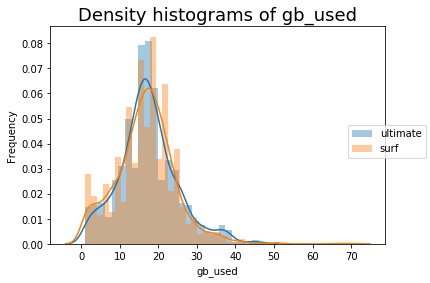

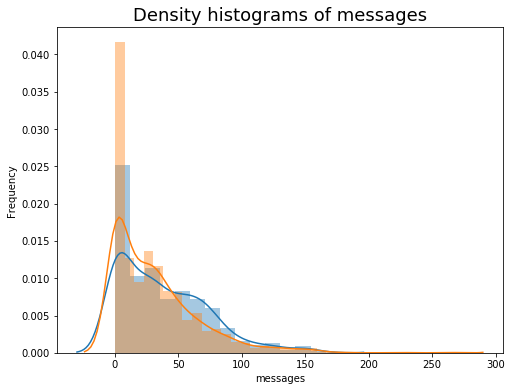

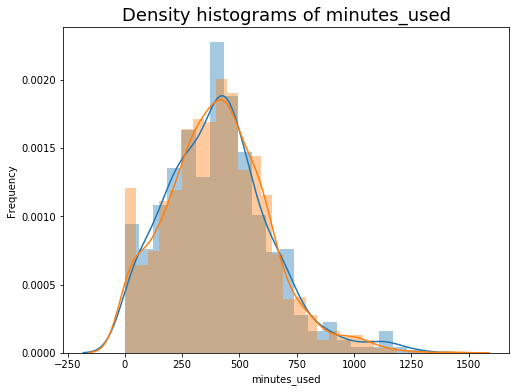

In [69]:
fig = plt.figure()
axes = fig.subplots()

for i, col in enumerate(ultimate_parameters.columns):
        plt.figure(i, figsize=(8,6))
        sb.distplot(ultimate_parameters[col], label="ultimate")
        plt.title("Density histograms of " + ultimate_parameters.columns[i], fontsize=18)
        plt.ylabel('Frequency', fontsize=10)



for x, col in enumerate(surf_parameters.columns):
        plt.figure(x, figsize=(8,6))
        sb.distplot(surf_parameters[col], label="surf")
        plt.title("Density histograms of " + surf_parameters.columns[x], fontsize=18)
        plt.ylabel('Frequency', fontsize=10)



lines, labels = fig.axes[0].get_legend_handles_labels()   
fig.legend(lines, labels, loc = 'center right')

plt.show()

We see the same patterns as saw on the boxplots (which is logical): users of ultimate plan on average send more messages, the density of GB and minutes used for both plans are almost the same, but surf plan contains more outliers.

### Step 4. Test the hypotheses

>- The average profit from users of Ultimate and Surf calling plans differs.
- The average profit from users in NY-NJ area is different from that of the users from other regions.

>Explain:
- How you formulated the null and alternative hypotheses.
- What criterion you used to test the hypotheses and why.

In [70]:
total.head(2)

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,...,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used,mes_above_limit,gb_above_limit,min_above_limit,total_cost
0,1000,12,1901.47,16.0,116.83,11.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,12,...,7,0.01,0.01,2,30.0,117,0,0,0,70.0
1,1001,8,6919.15,27.0,171.14,30.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",0.0,8,...,10,0.03,0.03,7,15.0,172,0,0,0,20.0


- We have two data sets: profit from users of Ultimate and Surf calling plans. 

- I'll test the hypothesis on the equality of 2 population means.

- The Null hypothesis (H0) is that the average monthly profit of the 2 tariffs are equal.

- The Alternative hypothesis (H1) is that the average monthly profit of the 2 tariffs are different.

- Let the significance level be 0.05.

In [71]:
profit_ultimate = plan_ultimate.pivot_table(index='user_id', values=['total_cost']).reset_index()
profit_surf = plan_surf.pivot_table(index='user_id', values=['total_cost']).reset_index()
profit_ultimate_avg = profit_ultimate['total_cost']
profit_surf_avg = profit_surf['total_cost']
print('AVG profit ultimate:', profit_ultimate_avg.mean())
print('AVG profit surf:', profit_surf_avg.mean())

AVG profit ultimate: 71.8486917562724
AVG profit surf: 57.586481000843214


In [72]:
profit_ultimate_st_dev = np.std(profit_ultimate_avg) 
profit_surf_st_dev = np.std(profit_surf_avg) 
print('Standard deviation of profit for ultimate plan', profit_ultimate_st_dev)
print('Standard deviation of profit for surf plan', profit_surf_st_dev)

Standard deviation of profit for ultimate plan 7.4455520314303065
Standard deviation of profit for surf plan 43.25595529685135


In [73]:
alpha = 0.05 

results = st.ttest_ind(
        profit_ultimate_avg, 
        profit_surf_avg)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 5.523315537344991e-05
We reject the null hypothesis


In addition I'll do the The Mann-Whitney U test, as is often considered the nonparametric alternative to the independent t-test although this is not always the case.

In [74]:
alpha = 0.05 

stat, p = mannwhitneyu(profit_ultimate_avg, profit_surf_avg)
print('Statistics=%.3f, p=%.3f' % (stat, p))

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

Statistics=12774.500, p=0.000
We reject the null hypothesis


The analysis suggests that users spend different amount of money for 2 plans.

- The next step is to test the hypothesis of average profit from users in NY-NJ area is different from that of the users from other regions.

- First step is to split data on 2 samples: NY-NJ region and other region.
Second - test the hypothesis.

- I'll test the hypothesis on the equality of 2 population means.

- The Null hypothesis (H0) is that the average monthly profit of the all regions are equal.

- The Alternative hypothesis (H1) is that the average monthly profit of the NY-NJ regions and all others are different.

- The significance level is 0.05.

In [75]:
total['city'].sample()

1357    Dallas-Fort Worth-Arlington, TX MSA
Name: city, dtype: object

In [76]:
NY_NJ_regions = total[total.city.str.contains('NY-NJ', case=False)]
NY_NJ_regions.sample()

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,...,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used,mes_above_limit,gb_above_limit,min_above_limit,total_cost
867,1181,10,18317.73,70.0,444.09,33.0,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",0.0,4,...,10,0.03,0.03,18,15.0,445,0,3,0,50.0


In [77]:
Other_regions = total[total.city.str.contains('NY-NJ') == False]

In [78]:
Other_regions.sample()

,user_id,month,mb_used,calls,duration,messages,plan,city,churn_month,reg_month,...,usd_per_gb,usd_per_message,usd_per_minute,gb_used,gb_per_month_included,minutes_used,mes_above_limit,gb_above_limit,min_above_limit,total_cost
282,1062,9,14532.52,36.0,192.05,8.0,ultimate,"San Antonio-New Braunfels, TX MSA",0.0,2,...,7,0.01,0.01,15,30.0,193,0,0,0,70.0


In [79]:
NY_NJ_regions_avg = NY_NJ_regions.pivot_table(index='user_id', values=['total_cost']).reset_index()
Other_regions_avg = Other_regions.pivot_table(index='user_id', values=['total_cost']).reset_index()
NY_NJ_profit = NY_NJ_regions_avg['total_cost']
Other_profit = Other_regions_avg['total_cost']

In [80]:

alpha = 0.05 

results = st.ttest_ind(
        NY_NJ_profit, 
        Other_profit)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.4916828695737592
We can't reject the null hypothesis


And additional valdation with the Mann-Whitney U test.

In [81]:
alpha = 0.05 

stat, p = mannwhitneyu(NY_NJ_profit, Other_profit)
print('Statistics=%.3f, p=%.3f' % (stat, p))

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

Statistics=15301.500, p=0.236
We can't reject the null hypothesis


The analysis suggests that users don't spend different amount of money in NY_NJ region and all other regions.

The p-value tells us that there is a 49% probability of randomly getting a difference that size or larger. This probability is too high to conclude that there is a significant difference between the average amounts spent on NY_NJ region and others.

### Step 5. Write an overall conclusion

I analyzed customers behavior who use services of telecom operator Megaline for 2 prepaid plans: Surf and Ultimate.

- The boxplots show that users of Ultimate plan on average send more messages per month, then users of Surfs plan.

- The distribution of GB and minutes used is almost the same for both plans, but the surf plan shows more outliers for the same parameters.

- Density histograms for surf plan have a normal distribution with the right skewness.

- Density histograms for the ultimate plan doesn't have a normal distribution. Most of the data concentrated at point 70$.

- According to hypothesis testing, density diagrams, means, and standard deviations for 2 plans, I would propose the managers of Megaline to promote Ultimate tariff, because after summarising all listed factors, I can make a conclusion that this plan is more profitable.